# Calculate projection effects in redmapper

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sigma_z.sigma_z import CosmoDC2SigmaZ, LambdaModel, DC2SigmaZ
from util.plot_helper import PlotHelper
from sigma_z.data_loader import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle

%matplotlib inline

The PlotHelper has a lot of boilerplate code to build plots with the correct font size and colors.

In [2]:
PlotHelper.set_defaults(matplotlib)

Here we specify the following: 
* The z-range and step size used by redmapper 
* The config file which specifies the column mappings
* The model we want to use to fit the $\lambda(z)$ curves

In [3]:
# z-scan redmapper inputs
zstart = 0.1
zend = 1.15
zstep = 0.005

#myCat = CosmoDC2SigmaZ('config/zscan_config.yaml', LambdaModel, zstart, zend, zstep)

myCat = DC2SigmaZ('config/zscan_config_dc2.yaml', LambdaModel, zstart, zend, zstep)
data = myCat.get_data()

z_in = data['z_in']
lambda_in = data['lambda_in']
lambda_arrays = data['lambda_arrays']

`delta_z` sets the redshift range around `z_in` used to fit the data. The smaller the value the better the fit to the peak of $\lambda(z)$.  Increase the value to fit also the tail of $\lambda(z)$. `delta_z=0.1` is a good compromise to correctly fit clear l.o.s. systems and moderately disturbed ones

`delta_lambda` sets the lowever values of $\lambda(z)$ (relative to the maximum $\lambda(z)$ values) used in the fit
A value of 20% is recommended in real data to avoid fitting the often disturbed tails of the $\lambda(z)$ distribution



In [4]:
delta_z = 0.1
delta_lambda = 0.2

Here we fit one $\lambda(z)$ curve, and plot the fitted curve to the actual 

0.746790120285961 0.13341589629558664 21.09988458067137


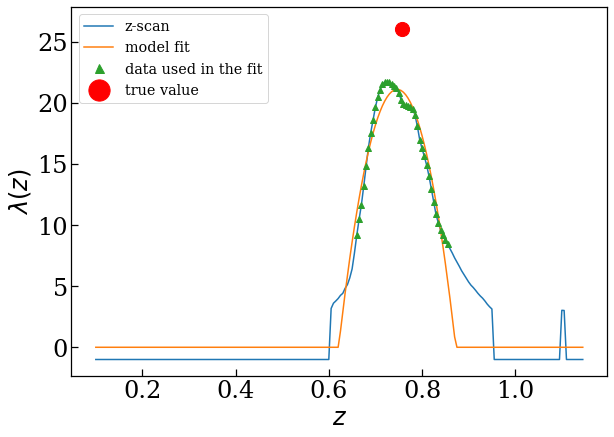

In [5]:
idx=800# Index of the cluster you want to check
fit = myCat.fit_model_by_id(idx, z_in[idx], lambda_in[idx], lambda_arrays[idx], delta_z, delta_lambda)

z_best = fit['z_best']
sigmaz_best = fit['sigmaz_best']
lambda_best = fit['lambda_best']

print(z_best, sigmaz_best, lambda_best)

PlotHelper.plot_model_vs_data(plt, LambdaModel, z_best, sigmaz_best, lambda_best, z_in[idx], lambda_in[idx], myCat.z_domain, lambda_arrays[idx], delta_z, delta_lambda)

Define sig_z_kernel according to Eq. 9 of the Projection effect paper (https://arxiv.org/pdf/1807.07072.pdf)

With this transformation `sig_z_kernel` represents the width of the parabola used to fit $\lambda(z)$

Great. Let's proceed with every other cluster and save the outputs.

In [6]:
print(len(z_in), len(lambda_in), len(lambda_arrays))

2819 2819 2819


In [7]:
model_fits = myCat.fit_model_all(z_in, lambda_in, lambda_arrays, delta_z, delta_lambda)

chis = model_fits['chis_all']
zpeaks = model_fits['zpeak_all']
lambda_peaks = model_fits['lambdapeak_all']
sigmaz_all = model_fits['sigmaz_all']
sig_z_kernel = model_fits['sig_z_kernel']

At cluster 0
At cluster 500
At cluster 1000
At cluster 1500
At cluster 2000
At cluster 2500


Plot the chis distribution (note this is not the $\chi^2$ value). You can use chis to assess the goodness of the fit, e.g. see below

Text(0.5, 1.0, 'Goodness-of-fit (100 bins)')

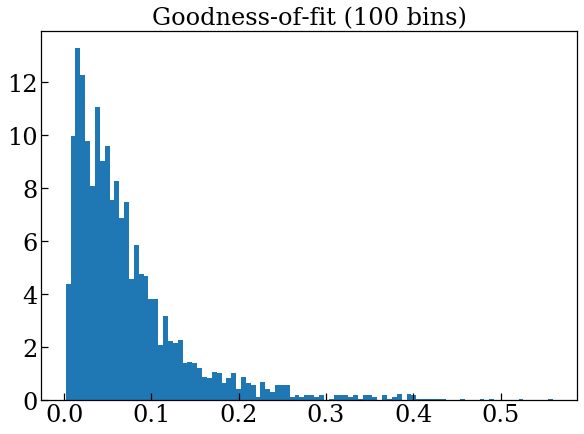

In [8]:
plt.hist(chis,bins=100,density=True)
plt.title("Goodness-of-fit (100 bins)", fontsize=24)

Below is a helper method to help visually inspect poor model fits.  Provide the condition as well as the model and the helper function will return a plot of 10 fits that match your condition.

Here we're looking at plots where our goodness-of-fit is worse than 0.3

157


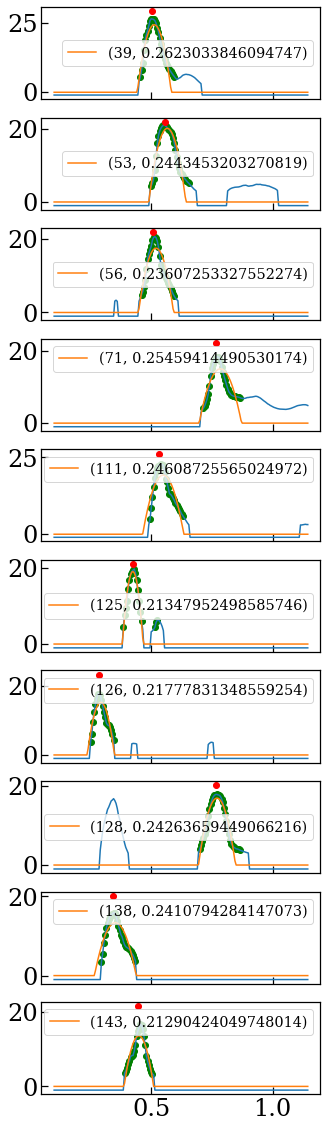

In [9]:
# Example of a systems with bad chis
cond=(chis>0.2)

PlotHelper.plot_sample(
    plt, cond, z_in, myCat.z_domain, 
    lambda_arrays, lambda_in, LambdaModel, sigmaz_all, zpeaks, 
    lambda_peaks, chis
)

Based on the above, we decided outliers lie beyond `chi=0.3` and `sig_z_kernel > 1`.  Here we filter out that data, and plot the scatter plot. 

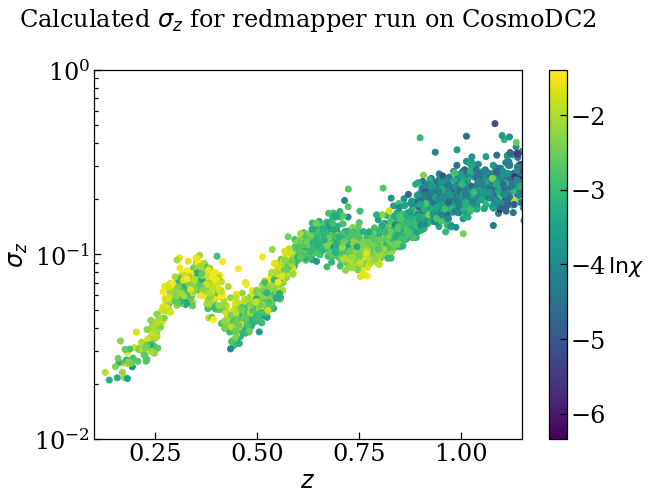

In [10]:
chi_filter = 0.25
sig_z_filter = 1
combined_filter = (chis <= chi_filter) & (sig_z_kernel < 1)

sigma_z_filtered = sig_z_kernel[combined_filter]
z_peaks_filtered = zpeaks[combined_filter]
chis_filtered = chis[combined_filter]

PlotHelper.plot_sigmaz_scatter(plt, z_peaks_filtered, sigma_z_filtered, chis_filtered)

Now, we average the `sig_z_kernel` in each bin, and plot the results vs other known real and simulated catalogs.

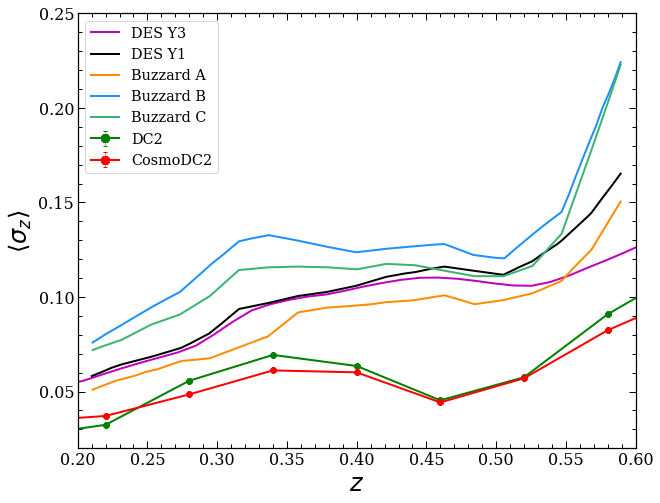

In [15]:
bin_start = 0.1
bin_end = 1.16
step_size = 0.06
(avg, sem, z_bins) = myCat.average_by_bin(z_peaks_filtered, sigma_z_filtered, bin_start, bin_end, step_size)

import math
sem = [0 if math.isnan(x) else x for x in sem]
data = pickle.load(open("data/cosmoDC2_values.pkl", "rb"))


fig, ax = plt.subplots(1,1, figsize=(10, 8))
PlotHelper.plot_avg_combined_plot(fig, ax, plt, z_bins, avg, sem, data)

In [12]:
import pickle
saveData = {}
saveData['sz'] = avg
saveData['err'] = sem
saveData['bins'] = z_bins
pickle.dump(saveData, open("data/DC2_values.pkl", "wb"))

In [26]:
data = pickle.load(open("data/cosmoDC2_values.pkl", "rb"))
print(data)

{'sz': [0.033862978242809226, 0.03406126708626347, 0.03709135524656168, 0.04851352973702358, 0.061191325341717735, 0.06017242883504927, 0.044269914872469694, 0.05703289960344085, 0.08245989715062356, 0.101601300945423, 0.09512186935059481, 0.07807395288974467, 0.09573368939705287, 0.1093046618535297, 0.1077561916549179, 0.11612205373689048, 0.143022445026701, 0.16191970892884477], 'err': [0.0006992337187908493, 0.000777254123884585, 0.0009655784861665268, 0.0005224277132829999, 0.0006228614179883633, 0.0005428967612804416, 0.00044307562595572396, 0.0004976814535504643, 0.0004731928017921417, 0.0003623859407899016, 0.00043599194798043953, 0.0006256361404091742, 0.0005049336838058547, 0.0003391506720625794, 0.0006142062920229722, 0.0007269420787759512, 0.0007306669700180881, 0.0008594750274075336], 'bins': array([0.1 , 0.16, 0.22, 0.28, 0.34, 0.4 , 0.46, 0.52, 0.58, 0.64, 0.7 ,
       0.76, 0.82, 0.88, 0.94, 1.  , 1.06, 1.12])}
